This project will utilize logistic regression to predict whether or not passengers of the Titanic survived its sinking. I'll begin with data cleaning and EDA using pandas, then I'll utilize Logit from Statsmodels for preprocessing and feature selection. Finally, I'll build a prediction model with LogisticRegression from Scikit-Learn.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, \
precision_score, recall_score, f1_score, auc
from sklearn.decomposition import PCA

In [31]:
# Load train data
train = pd.read_csv('train.csv')
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Null values are already visible in the Cabin column. I'll check the rest for missing entries.

In [32]:
# Check train for null values
print(train.isna().sum().sort_values(ascending=False))

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


Starting with the Age column, I'll visualize the distribution to decide on a fill method.

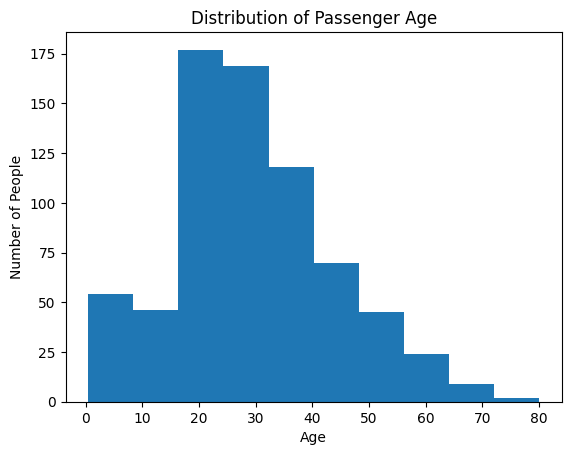

In [33]:
# Plot distribution of Age column
plt.hist(train.Age)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Distribution of Passenger Age')
plt.show()
plt.close()

The distribution is skewed right, so I'll use the median of ages to populate null values to account for extremes.

In [34]:
# Fill null values with median age
train.Age = train.Age.fillna(train.Age.median())

Now to view the Cabin column.

In [35]:
# View non-null Cabin values
print(train.loc[train.Cabin.notna(), 'Cabin'].head(10))

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object


Currently, the column values are not of much use as features because they are too unique and numerous. I'm going to transform them into something more workable. The Titanic's cabin designations are formatted with a letter indicating the deck level followed by a cabin number. I'll isolate the deck levels to use as features, filling nulls with "Unknown".



In [36]:
# Isolate deck level from Cabin designations
train.Cabin = train.Cabin.str.replace(r'\d+', '', regex=True)

# Remove duplicate designations
train.Cabin = train.Cabin.str.extract(r'([A-Z])$', expand=False)

# Fill null values in Cabin column with 'Unknown'
train.Cabin = train.Cabin.fillna('Unknown')

# Rename Cabin column: Deck
train = train.rename(columns={'Cabin': 'Deck'})

# View new Deck values
print('Decks: ', train.Deck.unique())

Decks:  ['Unknown' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


"T" was likely recorded erroneously as there was no T deck on the Titanic. I'll include it with the Unknown deck.

In [37]:
# Replace 'T' deck with 'Unknown'
train.Deck = train.Deck.str.replace('T', 'Unknown')

# View decks
print('Decks: ', train.Deck.unique())

Decks:  ['Unknown' 'C' 'E' 'G' 'D' 'A' 'B' 'F']


Now that the deck levels have been isolated, because there is such a large number of entries that are missing, I'll check the distribution grouped by ticket class.

In [38]:
# View distribution of Deck levels by ticket class
print(train.groupby('Pclass')['Deck'].value_counts())

Pclass  Deck   
1       C           59
        B           47
        Unknown     41
        D           29
        E           25
        A           15
2       Unknown    168
        F            8
        D            4
        E            4
3       Unknown    479
        G            7
        E            4
        F            1
Name: count, dtype: int64


There's a lot of missing values for 2nd and 3rd-class passengers! Unfortunately, due to the amount of missing data, the Deck levels will be of no value to the model. Since the Passenger IDs, Names and Ticket codes won't be useful either, I'll drop them as well. In addition, the Embarked column contains only two missing values, so I'll just remove those rows.

In [39]:
# Drop missing rows
train_clean = train.dropna()

# Drop unnecessary columns
train_subset = train_clean.drop(['PassengerId', 'Name', 'Ticket', 'Deck'],
                                axis=1)
print(train_subset.head())

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


To transform the data for the model, I'll use a mix of encoding methods. Sex will be binary encoded and Embarked will be one-hot encoded since it contains three non-ordinal categories.

In [40]:
# Create an encoded copy of train_clean
train_enc = train_subset.copy()

# Encode Sex, Embarked
train_enc.Sex = train_enc.Sex.apply(lambda x: 0 if x == 'male' else 1)
train_enc = pd.concat([train_enc, pd.get_dummies(train_enc.Embarked,
                                                 prefix='Embarked',
                                                 drop_first=True)\
                                                 .astype('int')], axis=1)
train_enc.drop('Embarked', axis=1, inplace=True)
print(train_enc.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_Q  Embarked_S
0         0       3    0  22.0      1      0   7.2500           0           1
1         1       1    1  38.0      1      0  71.2833           0           0
2         1       3    1  26.0      0      0   7.9250           0           1
3         1       1    1  35.0      1      0  53.1000           0           1
4         0       3    0  35.0      0      0   8.0500           0           1


I'll now check the distributions of each feature to help inform how to proceed with data preprocessing.

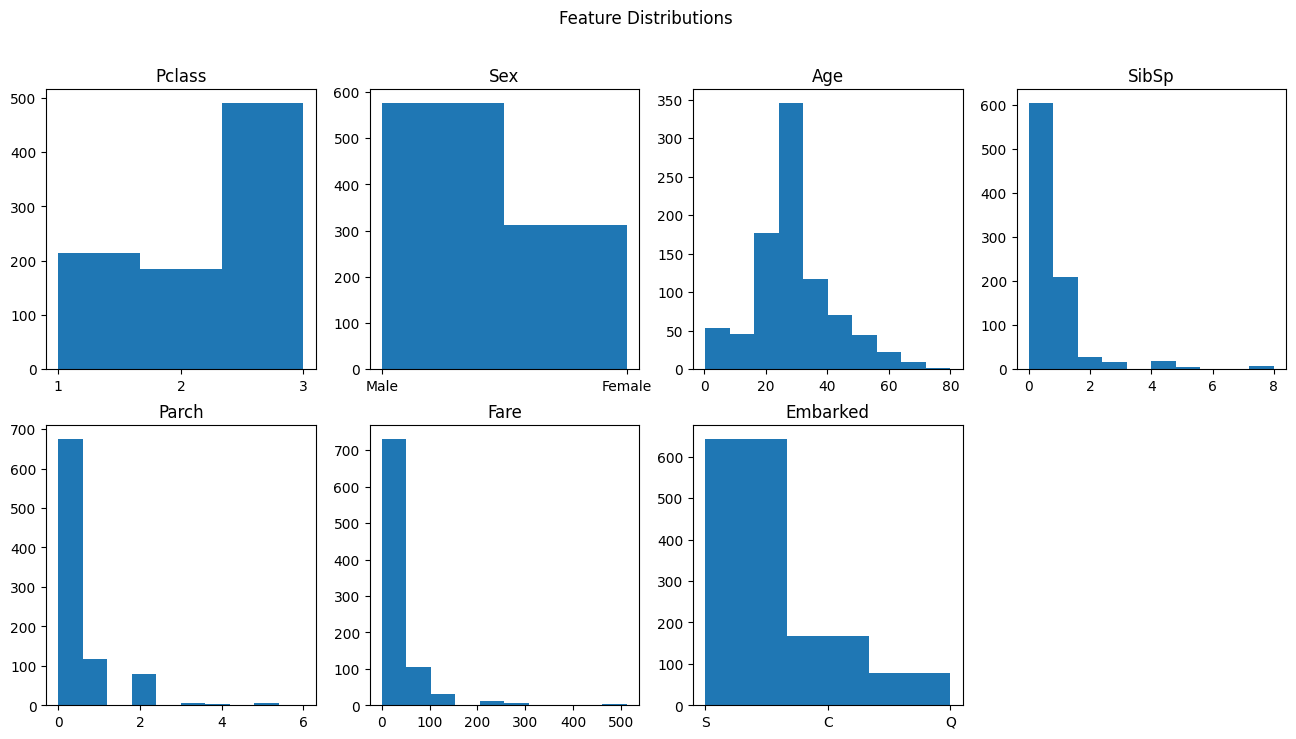

In [41]:
# Create axes subplots for each feature
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs.flat[:7]
fig.delaxes(axs.flat[7])

# Plot distributions of each feature
ax1.hist(train_enc.Pclass, bins=3)
ax1.set_title('Pclass')
ax1.set_xticks([1, 2, 3])
ax2.hist(train_enc.Sex, bins=2)
ax2.set_title('Sex')
ax2.set_xticks(ticks=[0, 1], labels=['Male', 'Female'])
ax3.hist(train_enc.Age)
ax3.set_title('Age')
ax4.hist(train_enc.SibSp)
ax4.set_title('SibSp')
ax5.hist(train_enc.Parch)
ax5.set_title('Parch')
ax6.hist(train_enc.Fare)
ax6.set_title('Fare')
ax7.hist(train_subset.Embarked, bins=3)
ax7.set_title('Embarked')
ax7.set_xticks(['S', 'C', 'Q'])
fig.suptitle('Feature Distributions')
plt.show()
plt.close()

The model may be extremely imbalanced as over half of the observations are third-class, nearly twice as many men, majority in their 30s, and most with no siblings/spouses or parents/children onboard. I may need to implement resampling techniques to counter this, and since the feature distibutions are all skewed I'll need to scale them before fitting them to the model.

Now I will check the variance of my continuous features.

In [42]:
# Feature variance
print(train_enc[['Age', 'Fare']].var())

Age      168.608467
Fare    2469.841935
dtype: float64


Age and Fare display high variation, so I'll apply log normalization.

In [43]:
# Normalize Age, Fare
train_enc.Age = np.log(train_enc.Age)
train_enc.Fare = train_enc.Fare.apply(lambda x: x if x == 0 else np.log(x))
print(train_enc[['Age', 'Fare']].var())

Age     0.496178
Fare    1.003072
dtype: float64


Next, I'll check the correlation between features. Since the Age and Fare are continuous variables, I'll evaluate using the Pearson correlation coefficient. The other features will be evaluated using Kendall's tau.

In [44]:
# Age, Fare pearson correlation
print('Age/Fare: ')
print(np.corrcoef(train_enc.Age, train_enc.Fare), '\n')

# Kendall correlation remaining columns
print('Remaining Features:')
print(train_enc[['Pclass', 'Sex', 'SibSp', 'Parch',
                 'Embarked_Q', 'Embarked_S']].corr(method='kendall'))

Age/Fare: 
[[1.         0.00117393]
 [0.00117393 1.        ]] 

Remaining Features:
              Pclass       Sex     SibSp     Parch  Embarked_Q  Embarked_S
Pclass      1.000000 -0.125685 -0.041662 -0.022778    0.218509    0.048532
Sex        -0.125685  1.000000  0.191131  0.248770    0.075217   -0.121405
SibSp      -0.041662  0.191131  1.000000  0.424805   -0.047378    0.018456
Parch      -0.022778  0.248770  0.424805  1.000000   -0.096551    0.041680
Embarked_Q  0.218509  0.075217 -0.047378 -0.096551    1.000000   -0.499261
Embarked_S  0.048532 -0.121405  0.018456  0.041680   -0.499261    1.000000


Correlations are generally low which is good. The features will all contribute uniquely to the model. There is a moderate correlation between number of siblings/spouses and number of parents/children traveling together which makes sense.

Before I begin building a Logit model, I'll check the class weights of Survived -- the target variable.

In [45]:
# Create a dictionary for class weights
class_weights = dict(round(train_enc.Survived.value_counts(normalize=True), 3))
print(class_weights)

{0: 0.618, 1: 0.382}


Due to the moderate class imbalance, I'll assign these weights to the target variables before fitting the model. The data will also need to be scaled to account for skew.

Optimization terminated successfully.
         Current function value: 0.429549
         Iterations 6


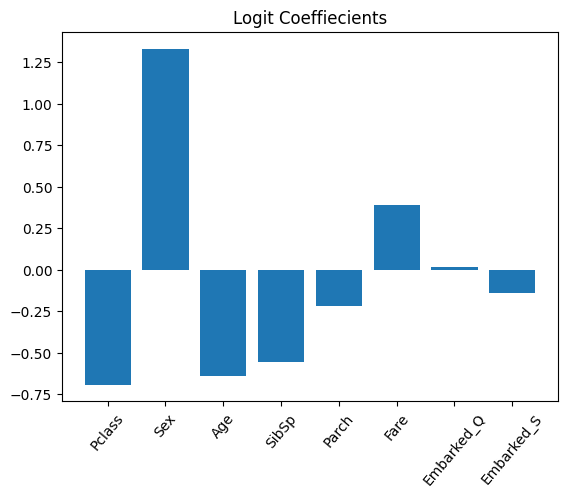

<Figure size 640x480 with 0 Axes>

In [46]:
# Create model features and label
features = train_enc.drop('Survived', axis=1)
label = train_enc.Survived.reset_index(drop=True)

# Create scaler
scaler = StandardScaler()

# Scale X features
features_scaled = pd.DataFrame(scaler.fit_transform(features),
                               columns=features.columns)

# Instantiate Logit model
warnings.simplefilter('ignore', FutureWarning)  # block unnecessary output
lgt = sm.Logit(label, sm.add_constant(features_scaled))\
                .fit(weights=class_weights)

# Plot model coefficients
plt.bar(lgt.params.index[1:], lgt.params.values[1:])
plt.title('Logit Coeffiecients')
plt.xticks(rotation=50)
plt.show()
plt.clf()

The coefficients suggest strong predictive influence from most of the features. Parch and the Embarked features seem to have little influence on the model but they may still be useful. I'll extract these features' P-values as a significance test.

In [47]:
# View P-values
p_values = lgt.pvalues
print(round(p_values, 3).sort_values(ascending=False))

Embarked_Q    0.878
Embarked_S    0.199
Parch         0.035
Fare          0.019
const         0.000
Pclass        0.000
Sex           0.000
Age           0.000
SibSp         0.000
dtype: float64


It appears the the Embarked features are not statistically significant and provide nothing to the model. Keeping them will likely contribute noise to the model, so I'll remove them.

In [48]:
# Remove unnecessary features
features_scaled = features_scaled.drop(['Embarked_Q', 'Embarked_S'], axis=1)
print(features_scaled.head())

     Pclass       Sex       Age     SibSp     Parch      Fare
0  0.825209 -0.735342 -0.185193  0.431350 -0.474326 -0.908614
1 -1.572211  1.359911  0.591144  0.431350 -0.474326  1.374828
2  0.825209  1.359911  0.052098 -0.475199 -0.474326 -0.819680
3 -1.572211  1.359911  0.474329  0.431350 -0.474326  1.080629
4  0.825209 -0.735342  0.474329 -0.475199 -0.474326 -0.804045


Now that features have been selected, I'll refit the model and perform some predictions. I'll then use the results of the predictions to evaluate the model's performance across several metrics. To begin with, I'll evaluate the confusion matrix and related key metrics.

In [49]:
# Create array variables
X = features_scaled.values
y = label.values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=206)

# Add constants to features
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Refit the model
lgt = sm.Logit(y_train, X_train_const).fit(weights=class_weights)

# Run predictions
lgt_y_pred_proba = lgt.predict(X_test_const)
lgt_y_pred = (lgt_y_pred_proba >= 0.5).astype('int')

# Define model_metrics
def model_metrics(y_test, y_pred):
  """Prints precision, recall, F1-score and confusion matrix."""
  print(f'Precision: {precision_score(y_test, y_pred):.2f}')
  print(f'Recall: {recall_score(y_test, y_pred):.2f}')
  print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')
  print('Confusion Matrix:')
  print(confusion_matrix(y_test, y_pred))

# View confusion matrix, key metrics
model_metrics(y_test, lgt_y_pred)

Optimization terminated successfully.
         Current function value: 0.425123
         Iterations 6
Precision: 0.74
Recall: 0.73
F1 Score: 0.73
Confusion Matrix:
[[116  22]
 [ 23  62]]


The model has balanced precision and recall and does pretty well at identifying both classes.

Now I'll attempt to find a more optimal threshold for the model to boost F1-score and plot the result against a precision-recall curve.

In [50]:
# Calculate PR curve variables
lgt_precision, lgt_recall, lgt_thresholds = precision_recall_curve(
    y_test, lgt_y_pred_proba
)

# Define function to remove zero values
def remove_zeros(precision, recall):
  """Removes zero values from precision and recall arrays."""
  precision = precision[precision != 0][:-1]
  recall = recall[recall != 0]
  return precision, recall

# Remove zeroes
lgt_precision, lgt_recall = remove_zeros(lgt_precision, lgt_recall)

# Define function for isolating optimal threshold, F1-score
def optimal_threshold(precision, recall, thresholds):
  """Returns optimal threshold and F1-score, as well as the index location of
  the calculated array of F1-scores from the precision_recall_curve()
  output."""

# Calculate F1-scores
  f1_scores = 2 * ((precision * recall) / (precision + recall))

  # Isolate index of highest score
  optimal_idx = np.argmax(f1_scores)

  # Isolate threshold of highest score
  optimal_th = thresholds[optimal_idx]

  # Isolate highest score
  optimal_f1 = f1_scores[optimal_idx]

  # Return isolated values
  return optimal_idx, optimal_th, optimal_f1

# Isolate lgt optimal threshold, F1-score
lgt_opt_idx, lgt_opt_th, lgt_opt_f1 = optimal_threshold(
    lgt_precision, lgt_recall, lgt_thresholds
)
print(f'Optimal Threshold: {lgt_opt_th:.2f}')

Optimal Threshold: 0.34


Area Under Curve: 0.78 



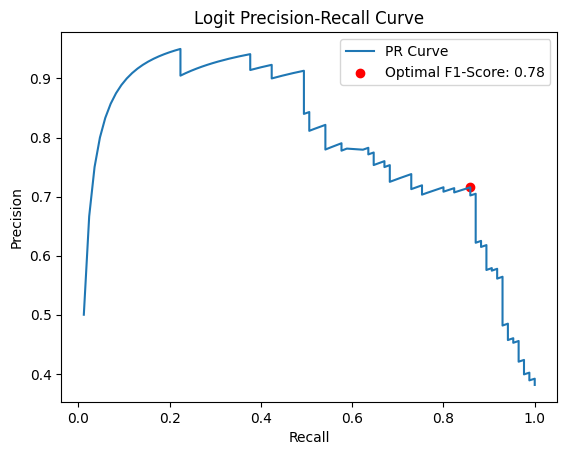

<Figure size 640x480 with 0 Axes>

In [51]:
# Calculate lgt AUC-PR
lgt_aucpr = auc(lgt_recall, lgt_precision)
print(f'Area Under Curve: {lgt_aucpr:.2f}', '\n')

# Define plot_prc
def plot_prc(name, recall, precision, optimal_idx, optimal_f1):
  """Plots precision-recall curve."""
  plt.plot(recall, precision, label='PR Curve')
  plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', c='r',
              label=f'Optimal F1-Score: {optimal_f1:.2f}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(name + ' Precision-Recall Curve')
  plt.legend()
  plt.show()

# Plot precision-recall curve
plot_prc('Logit', lgt_recall, lgt_precision, lgt_opt_idx, lgt_opt_f1)
plt.clf()

The precision-recall curve shows that the model has sharp drop in precision at around 0.5 recall. If I were focusing on precision that'd be a great threshold, but it would be a much more conservative model. To improve accurate predictions of the positive class, the model sacrifices some precision.

Now I will use the optimal threshold to view the change in the confusion matrix.

In [52]:
# View confusion matrix, key metrics
lgt_y_pred_optimal = (lgt_y_pred_proba >= lgt_opt_th).astype('int')
model_metrics(y_test, lgt_y_pred_optimal)

Precision: 0.72
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[109  29]
 [ 12  73]]


With the optimal threshold it appears the the F1-Score increased at a slight cost to precision. Recall also dramatically increased meaning that the model has become better at predicting the minority class. This will be a good benchmark to compare to the LogisticRegression model I'll be building next. I'll also take a look at the model's decision boundary just for fun.

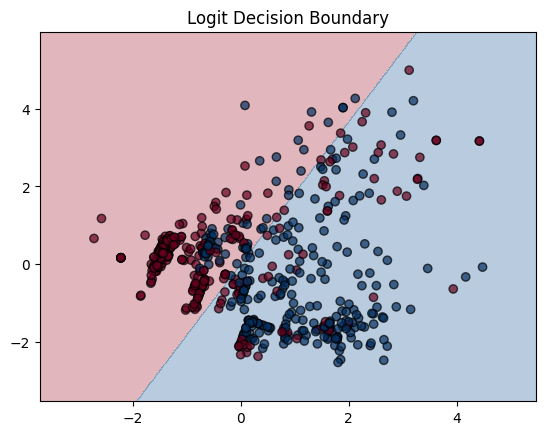

<Figure size 640x480 with 0 Axes>

In [53]:
# Reduce dimensionality for decision boundary
pca = PCA(n_components=2)
lgt_X_train_pca = pca.fit_transform(X_train_const[1:])

# Predict labels for train set
lgt_y_pred_train = (lgt.predict(X_train_const[1:]) >= lgt_opt_th)\
                .astype('int')

# Define plot_db
def plot_db(model, X, y, optimal_th, name=None):
  """Plots decision boundary of model."""
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                       np.arange(y_min, y_max, 0.02))
  Z_prob = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
  Z = (Z_prob >= optimal_th).astype('int')
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
  plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.7, edgecolor='k', cmap='RdBu')
  plt.title(name + ' Decision Boundary')
  plt.show()

# Plot decision boundary
plot_db(lgt, lgt_X_train_pca, lgt_y_pred_train, lgt_opt_th, 'Logit')
plt.clf()

It seems most of the data points are being correctly predicted, although there is a lot of overlap suggesting features in those regions are not being interpreted as well by the model. Furthermore, the positive observations are mainly clustering in a single area, meaning that the model may be primarily using only one or two features to make predictions for the positive class.

Now, I'll proceed with building the LogisticRegression model. The goal will be to discover an optimal tuning strategy as well as attempting resampling techniques to improve overall performance. First, I'll compare feature coefficients with the Logit model to see if there are any differences in how LogisticRegression interprets the data.

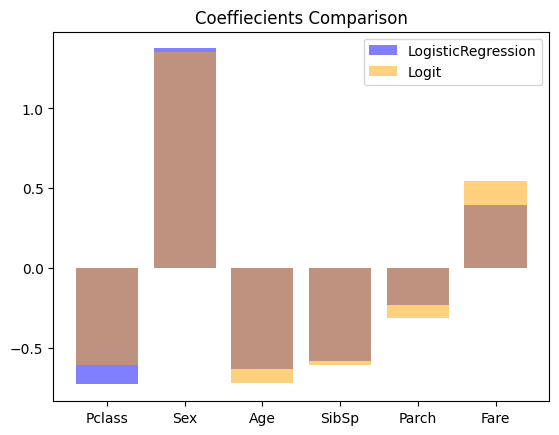

<Figure size 640x480 with 0 Axes>

In [54]:
# Instantiate LogisticRegression model
lr = LogisticRegression(penalty=None, class_weight=class_weights,
                            random_state=206)

# Fit model with label and features
lr.fit(features_scaled, label)

# Plot coefficient comparison
plt.bar(features_scaled.columns, lr.coef_[0], label='LogisticRegression',
        color='b', alpha=0.5)
plt.bar(features_scaled.columns, lgt.params[1:], label='Logit',
        color='orange', alpha=0.5)
plt.title('Coeffiecients Comparison')
plt.legend()
plt.show()
plt.clf()

It looks like most of the coeffiecients are a bit weaker for the LogisticRegression model, but the general interpretation of the data is the same among both models. Now to refit the model on the split training set and run cross-validation. I'll set the solver method to liblinear, which is ideal for this dataset, and use a grid search with a stratified K-fold method to tune hyperparameters.

In [55]:
# Instantiate new lr
lr = LogisticRegression(class_weight=class_weights, random_state=206,
                            solver='liblinear')

# Create K-means object
skf = StratifiedKFold(shuffle=True, random_state=206)

# Create parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'C': [100, 10, 1, 0.1, 0.001, 0.0001],
    'intercept_scaling': [0.1, 0.5, 1, 2, 5, 10],
    'max_iter': [50, 100, 150, 200, 300]
}

# Run cross-validation
lr_cv = GridSearchCV(lr, param_grid, cv=skf, scoring='f1', n_jobs=-1)
lr_cv.fit(X_train, y_train)

# Isolate best parameters
print(lr_cv.best_params_)

{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


Now to tune the model and evaluate performance against the Logit model.

In [56]:
# Tune lr
lr_tuned = LogisticRegression(
    penalty='l2',
    tol=0.01,
    intercept_scaling=0.1,
    max_iter=50,
    class_weight=class_weights,
    random_state=206,
    solver='liblinear'
)

# Fit tuned model
lr_tuned.fit(X_train, y_train)

# Prediction probablities
lr_y_pred_proba = lr_tuned.predict_proba(X_test)[:, 1]

# Calculate PR curve variables
lr_precision, lr_recall, lr_thresholds = \
  precision_recall_curve(y_test, lr_y_pred_proba)

# Remove zeroes
lr_precision, lr_recall = remove_zeros(lr_precision, lr_recall)

# Isolate lr optimal threshold, F1-score
lr_optimal_idx, lr_optimal_th, lr_optimal_f1 = optimal_threshold(
    lr_precision, lr_recall, lr_thresholds
)
print(f'Optimal Threshold: {lr_optimal_th:.2f}')

Optimal Threshold: 0.41


Area Under Curve: 0.78 



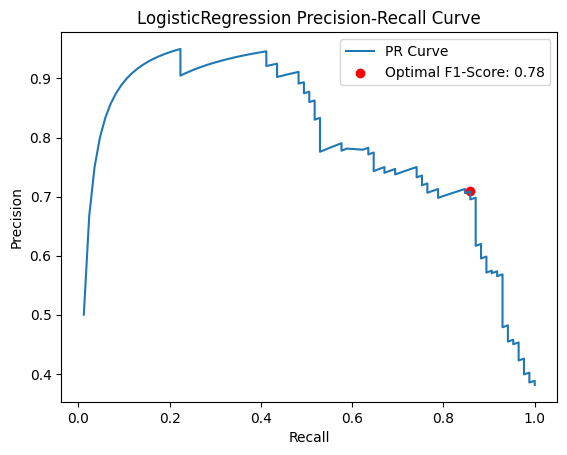

<Figure size 640x480 with 0 Axes>

In [57]:
# Calculate lr AUC-PR
lr_aucpr = auc(lr_recall, lr_precision)
print(f'Area Under Curve: {lr_aucpr:.2f}', '\n')

# Plot PR curve
plot_prc('LogisticRegression', lr_recall, lr_precision, lr_optimal_idx,
         lr_optimal_f1)
plt.clf()

The PR curve for LogisticRegression look almost identical! With even the same AUC score, both models are drawing much the same conclusions from the data. Now to take a look at the confusion matrix.

In [58]:
# View confusion matrix, key metrics comparison
lr_y_pred = (lr_y_pred_proba >= lr_optimal_th).astype('int')
print('--LogisticRegression--')
model_metrics(y_test, lr_y_pred)
print('\n--Logit--')
model_metrics(y_test, lgt_y_pred_optimal)

--LogisticRegression--
Precision: 0.71
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[108  30]
 [ 12  73]]

--Logit--
Precision: 0.72
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[109  29]
 [ 12  73]]


Both models are indeed nearly identical in performance, with the Logit model displaying just the slightest edge in precision. Moving forward, I'll try resampling the data with SMOTE to boost performance.

In [59]:
# Instantiate SMOTE object
smote = SMOTE(sampling_strategy='minority', random_state=206)
X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

# Instatiate lr smote model
lrs = LogisticRegression(random_state=206, solver='liblinear')

# Rerun CV
lrs_cv = GridSearchCV(lrs, param_grid, cv=skf, scoring='f1',
                               n_jobs=-1)
lrs_cv.fit(X_train_s, y_train_s)
print(lrs_cv.best_params_)

{'C': 0.001, 'intercept_scaling': 2, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


In [60]:
# Reinstantiate tuned smote model
lrs_tuned = LogisticRegression(
    penalty='l2',
    tol=0.01,
    C=1e-3,
    intercept_scaling=2,
    max_iter=50,
    random_state=206,
    solver='liblinear'
)
lrs_tuned.fit(X_train_s, y_train_s)
lrs_y_pred_proba = lrs_tuned.predict_proba(X_test)[:, 1]

# Isolate new optimal threshold, F1-score
lrs_precision, lrs_recall, lrs_thresholds = \
  precision_recall_curve(y_test, lrs_y_pred_proba)
lrs_precision, lrs_recall = remove_zeros(lrs_precision, lrs_recall)
lrs_optimal_idx, lrs_optimal_th, lrs_optimal_f1 = optimal_threshold(
    lrs_precision, lrs_recall, lrs_thresholds)
print(f'Optimal Threshold: {lrs_optimal_th:.2f}')

Optimal Threshold: 0.50


Area Under Curve: 0.75 



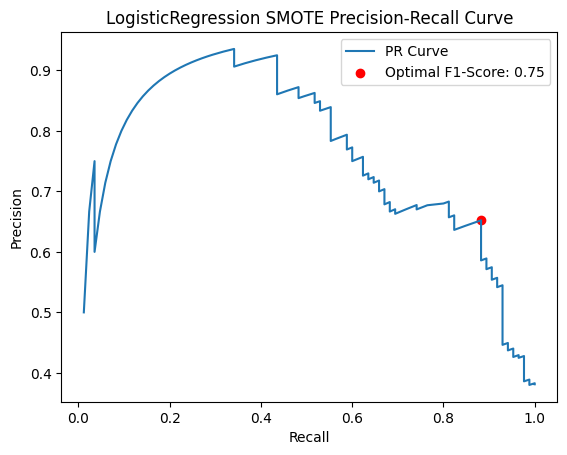

<Figure size 640x480 with 0 Axes>

In [61]:
# Calculate SMOTE AUC-PR
lrs_aucpr = auc(lrs_recall, lrs_precision)
print(f'Area Under Curve: {lrs_aucpr:.2f}', '\n')

# Plot PR curve
plot_prc('LogisticRegression SMOTE', lrs_recall, lrs_precision,
         lrs_optimal_idx, lrs_optimal_f1)
plt.clf()

The AUC score is slightly worse on the SMOTE model. It does not stay as precise as long across. I'll evaluate the metrics to learn more.

In [62]:
# View new confusion matrix, key metrics
lrs_y_pred = (lrs_y_pred_proba >= lrs_optimal_th).astype('int')
print('--LogisticRegression SMOTE--')
model_metrics(y_test, lrs_y_pred)
print('\n--LogisticRegression--')
model_metrics(y_test, lr_y_pred)

--LogisticRegression SMOTE--
Precision: 0.65
Recall: 0.88
F1 Score: 0.75
Confusion Matrix:
[[98 40]
 [10 75]]

--LogisticRegression--
Precision: 0.71
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[108  30]
 [ 12  73]]


As the PR curve showed, precision was lost for a slight increase in recall. Overall the model performed worse with SMOTE resampling as evidenced by the lower F1-score. Considering that this resampling technique did not yield satisfying results, I'll next attempt to use a random oversampling method.

In [63]:
# Instantiate oversampler
ros = RandomOverSampler(sampling_strategy='minority', random_state=206)

# Oversample training set
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Instantiate lr with the oversampled data
lr_ros = LogisticRegression(random_state=206, solver='liblinear')

# Run cross-validation for lr_ros
lr_ros_cv = GridSearchCV(lr_ros, param_grid, cv=skf, scoring='f1',
                             n_jobs=-1)
lr_ros_cv.fit(X_train_ros, y_train_ros)
print(lr_ros_cv.best_params_)

{'C': 100, 'intercept_scaling': 0.5, 'max_iter': 50, 'penalty': 'l2', 'tol': 0.01}


Depending on the result, I will repeat this step to explore the effect of increasing increments of shrinkage in the oversampling process.

In [64]:
# Refit model
lr_ros = LogisticRegression(
    penalty='l2',
    tol=0.01,
    C=100,
    intercept_scaling=0.5,
    max_iter=50,
    random_state=206,
    solver='liblinear'
)
lr_ros.fit(X_train_ros, y_train_ros)

# Isolate new optimal threshold, F1-score
lr_ros_y_pred_proba = lr_ros.predict_proba(X_test)[:, 1]
lr_ros_precision, lr_ros_recall, lr_ros_thresholds = \
  precision_recall_curve(y_test, lr_ros_y_pred_proba)
lr_ros_precision, lr_ros_recall = remove_zeros(lr_ros_precision,
                                                lr_ros_recall)
lr_ros_optimal_idx, lr_ros_optimal_th, lr_ros_optimal_f1 = optimal_threshold(
    lr_ros_precision, lr_ros_recall, lr_ros_thresholds)
print(f'Optimal Threshold: {lr_ros_optimal_th:.2f}')

Optimal Threshold: 0.45


Area Under Curve: 0.78 



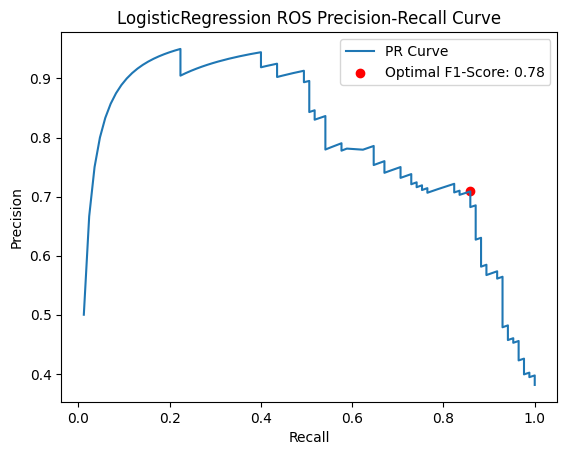

<Figure size 640x480 with 0 Axes>

In [65]:
# Calculate resampled AUC-PR
lr_ros_aucpr = auc(lr_ros_recall, lr_ros_precision)
print(f'Area Under Curve: {lr_ros_aucpr:.2f}','\n')

# Plot PR curve
plot_prc('LogisticRegression ROS', lr_ros_recall, lr_ros_precision,
         lr_ros_optimal_idx, lr_ros_optimal_f1)
plt.clf()

AUC score is tied with the initial model at 0.79. Now to check the confusion matrix and key metrics...

In [66]:
# View confusion matrix, key metrics
lr_ros_y_pred = (lr_ros_y_pred_proba >= lr_ros_optimal_th).astype('int')
print('--LogisticRegression ROS--')
model_metrics(y_test, lr_ros_y_pred)
print('\n--LogisticRegression--')
model_metrics(y_test, lr_y_pred)

--LogisticRegression ROS--
Precision: 0.71
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[108  30]
 [ 12  73]]

--LogisticRegression--
Precision: 0.71
Recall: 0.86
F1 Score: 0.78
Confusion Matrix:
[[108  30]
 [ 12  73]]


The random oversampled model performed identically to the initial Logistic Regression model. Since there was no loss in performance, I'll now run increments of shrinkage in the resampling method to try and boost F1-Score.

In [67]:
# Instantiate shrunk model
lr_ros_shrunk = LogisticRegression(random_state=206, solver='liblinear')

# Loop through shrinkage values
for shrinkage in np.linspace(0.1, 0.5, 5):
  ros = ros.set_params(shrinkage=shrinkage)
  X_train_shrunk, y_train_shrunk = ros.fit_resample(X_train, y_train)
  lr_ros_shrunk_cv = GridSearchCV(lr_ros_shrunk, param_grid, n_jobs=-1)
  lr_ros_shrunk_cv.fit(X_train_shrunk, y_train_shrunk)

  # Print results
  print(f'Shrinkage: {shrinkage:.1f}')
  print(lr_ros_shrunk_cv.best_params_)
  print(lr_ros_shrunk_cv.best_score_)

Shrinkage: 0.1
{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}
0.7919438285291944
Shrinkage: 0.2
{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.001}
0.7943828529194383
Shrinkage: 0.3
{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.0001}
0.7943828529194382
Shrinkage: 0.4
{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}
0.7943828529194382
Shrinkage: 0.5
{'C': 1, 'intercept_scaling': 0.1, 'max_iter': 50, 'penalty': 'l1', 'tol': 0.01}
0.7943828529194382


The hyperparameters don't change much across different levels of sampling shrinkage. This means that implementing shrinkage probably doesn't affect performance in any meaningful way. I'll loop through shrinkage values again with the same tuning as before for F1-scores as a final check.

In [68]:
# Loop through shrinkage values again with lr_ros configuration for F1-scores
for shrinkage in np.linspace(0.1, 0.5, 5):
  ros = ros.set_params(shrinkage=shrinkage)
  X_train_shrunk, y_train_shrunk = ros.fit_resample(X_train, y_train)
  y_pred_shrunk = (lr_ros.predict_proba(X_test)[:, 1] >= lr_ros_optimal_th)\
                  .astype('int')
  print(f'Shrinkage: {shrinkage:.1f}')
  print(f'F1-Score: {f1_score(y_test, y_pred_shrunk):.2f}')

Shrinkage: 0.1
F1-Score: 0.78
Shrinkage: 0.2
F1-Score: 0.78
Shrinkage: 0.3
F1-Score: 0.78
Shrinkage: 0.4
F1-Score: 0.78
Shrinkage: 0.5
F1-Score: 0.78


As suspected, no change in F1-Score. Since I haven't managed to boost LogisticRegression's performance any higher than the Logit model, I'll perform final predictions for submittal with Logit.

With the prediction model optimized, it's now ready to make final predictions. So I'll procced with fitting the lgt model on the full dataset.

---
---
NEW SECTION

Thanks to feedback from my peer, I'm going to try add a few additional steps to this project. Firstly, I'm going to compare the differences between the predictions of the Logit model and the LogisticRegression model. Their understanding of the data may be extremely similar, but their individual predictions may be different enough to leverage for a combined strategy.

In [69]:
# Create a dataframe with best predictions from Logit, LogisticRegression
pred_df = pd.DataFrame({
    'Logit': lgt_y_pred_optimal,
    'LogisticRegression': lr_y_pred
})

# Isolate the rows in which the predictions differ
print(pred_df[pred_df.Logit != pred_df.LogisticRegression])

    Logit  LogisticRegression
79      0                   1


Incredible! Of 223 predictions, both models predicted identically save for just one observation! I'll examine that passenger.

In [70]:
# Isolate the observation as a DataFrame
cols = features_scaled.columns
anomaly = pd.DataFrame(X_test[79], index=cols).T
print(anomaly)

     Pclass       Sex       Age     SibSp     Parch      Fare
0  0.825209  1.359911  0.157365  2.244449  0.765897  0.346537


In [71]:
# Match the observation with original set
row_match = features_scaled[(features_scaled == anomaly.iloc[0])\
                      .all(axis=1)]
print(row_match)

       Pclass       Sex       Age     SibSp     Parch      Fare
228  0.825209  1.359911  0.157365  2.244449  0.765897  0.346537
408  0.825209  1.359911  0.157365  2.244449  0.765897  0.346537
484  0.825209  1.359911  0.157365  2.244449  0.765897  0.346537


Looks like there are three matching rows in the original set, so the other two should be in X_train. I'll check just to make sure.

In [72]:
# Check for other matching observations in X_train
print('Matching rows in X_train: ', np.isin(X_train, row_match.to_numpy())\
                                      .all(axis=1).sum())

Matching rows in X_train:  2


As expected. Now to check the original observations in the train DataFrame.

In [73]:
print(train_subset.iloc[[228, 408, 484], :-2])

     Survived  Pclass     Sex   Age  SibSp  Parch
229         0       3  female  28.0      3      1
409         0       3  female  28.0      3      1
485         0       3  female  28.0      3      1


Looks like Logit made the correct prediction here. I wonder why LogisticRegression outputted a false positive prediction having been trained on two identical obversations already. I'll compare the probability scores and log-odds of each model.

In [74]:
# Compare anomaly probability scores, log-odds
print('Logit Probability: ', round(lgt_y_pred_proba[79], 2))
print('Logit Log-Odds: ', np.round(lgt.predict(X_test_const[79], linear=True),
                                   2))
print('\nLogisticRegression Probability: ', np.round(lr_y_pred_proba[79]\
                                                     .reshape(1, -1), 2))
print('LogisticRegression Log-Ldds: ', np.round(lr_tuned.decision_function(
    X_test[79].reshape(1, -1)), 2))

Logit Probability:  0.31
Logit Log-Odds:  [-0.81]

LogisticRegression Probability:  [[0.43]]
LogisticRegression Log-Ldds:  [-0.3]


It appears that the anomalous observation can be explained by the threshold settings of each model. LogisticRegression's threshold has been set at 0.41, and since its 43% percent confidence in positive class prediction beats the threshold, it falsely predicted a positive. This is a great example of a sacrifice made in our test set accuracy for a boost in F1-score.

END NEW SECTION

---
---

In [75]:
# Instantiate final model
lgt_final = sm.Logit(y, sm.add_constant(X)).fit(weights=class_weights)

Optimization terminated successfully.
         Current function value: 0.431034
         Iterations 6


Now I'll load in the final test set.

In [76]:
# Load test set
test = pd.read_csv('test.csv')
print(test.head())

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


I'll now apply the same preprocessing steps to the test DataFrame in preparation for predictions.

In [77]:
# Drop unused features
test_subset = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin',
                         'Embarked'], axis=1)

# Check for null values
print(test_subset.isna().sum().sort_values(ascending=False))

Age       86
Fare       1
Pclass     0
Sex        0
SibSp      0
Parch      0
dtype: int64


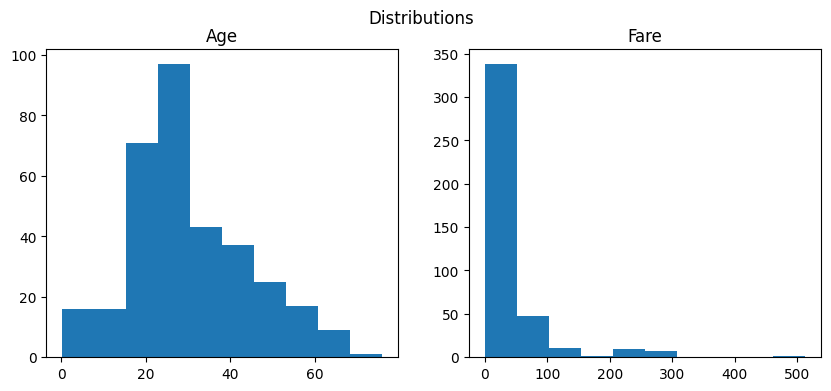

In [78]:
# Plot Age, Fare distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(test_subset.Age)
ax1.set_title('Age')
ax2.hist(test_subset.Fare)
ax2.set_title('Fare')
fig.suptitle('Distributions')
plt.show()
plt.close()

In [79]:
# Impute medians
test_subset.Age = test_subset.Age.fillna(test_subset.Age.median())
test_subset.Fare = test_subset.Fare.fillna(test_subset.Fare.median())
print(test_subset.isna().any().all())

False


In [80]:
# Encode Sex
test_enc = test_subset.copy()
test_enc.Sex = test_enc.Sex.apply(lambda x: 0 if x == 'male' else 1)

# Normalize Age, Fare
test_enc.Age = np.log(test_enc.Age)
test_enc.Fare = test_enc.Fare.apply(lambda x: x if x == 0 else np.log(x))

# Scale test set
test_scaled = pd.DataFrame(
    scaler.fit_transform(
        test_enc[
            ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare' ]
        ]
    ), columns=test_enc.columns
)
print(test_scaled.head())

     Pclass       Sex       Age     SibSp     Parch      Fare
0  0.873482 -0.755929  0.427432 -0.499470 -0.400248 -0.883366
1  0.873482  1.322876  0.875134  0.616992 -0.400248 -0.994751
2 -0.315819 -0.755929  1.276208 -0.499470 -0.400248 -0.671465
3  0.873482 -0.755929  0.072497 -0.499470 -0.400248 -0.782734
4  0.873482  1.322876 -0.224043  0.616992  0.619896 -0.434920


Now I'll run final predictions and export them.

In [81]:
# Fit final model on whole training set
lgt_final = sm.Logit(y, sm.add_constant(X)).fit(weights=class_weights)

# Run predictions
final_pred_proba = lgt_final.predict(sm.add_constant(test_scaled))
final_pred = (final_pred_proba >= lgt_opt_th).astype('int')

# Create a dictionary for submittal
submittal = {
    'PassengerId': test.PassengerId,
    'Survived': final_pred
}

# Create submittal DataFrame
submittal_df = pd.DataFrame(submittal)
print(submittal_df.head())

Optimization terminated successfully.
         Current function value: 0.431034
         Iterations 6
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


In [234]:
# Export final predictions
submittal_df.to_csv('submittal.csv')